In [1]:
## Import all the things

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import pycountry
import matplotlib.ticker as ticker
import datetime
# from scipy.stats import gaussian_kde
# from IPython.display import display, Markdown, Latex, display_markdown
from shapely.geometry import Point
# import folium
# from folium.plugins import HeatMap, HeatMapWithTime, MarkerCluster
# import os

# See plots in the notebook
%matplotlib inline 

# This allows cells with long text values to wrap
pd.set_option('display.max_colwidth', -1)

pd.set_option('max_rows', 200)

In [2]:
# Load data for maps

# bounding box
bbox = gpd.read_file("../../data_files/spatial-vector-lidar/global/ne_110m_graticules_all/ne_110m_wgs84_bounding_box.shp")
bbox_robinson = bbox.to_crs('+proj=robin')


# world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs(epsg=4326) #.to_crs('+proj=robin') # world map
world_robinson = world.to_crs('+proj=robin')


# Define constants - this will change with each report publication
report_date = pd.Timestamp(2018, 9, 30)




In [3]:
# Functions to clean up data

def get_country_name(alpha2_code):
    
    '''
    Takes a two character country code and
    returns the full name of the country.
    '''

    try:
        return pycountry.countries.get(alpha_2=alpha2_code).name
#         return pycountry.countries.
    except KeyError:
        if alpha2_code == "W3":
            return "online"
        else:
            return "unknown"
        
        
def get_country_code3(alpha2_code):
    
    '''
    Takes a two character country code and
    returns the full name of the country.
    '''

    try:
        return pycountry.countries.get(alpha_2=alpha2_code).alpha_3
#         return pycountry.countries.
    except KeyError:
        if alpha2_code == "W3":
            return "online"
        else:
            return "unknown"
        
        
# Function to create dataframes of counts and percentages by category (previous experience, expertise)
# when option is check many 
def get_value_counts_many(df, col_name, value_list):
    """
    Takes the parameters:
    * dataframe
    * the column in the df you want to group and count by
    * The list of characteristics (to ensure sort order)

    Returns a two column dataframe that has the grouped column and the count by that column

    
    """    
    
    df_counts = pd.DataFrame(columns=[col_name, 'Count'])
    
    for v in value_list:
#         count = df[col_name].apply(lambda x:x.count(v)).sum()
        count = df[col_name].str.count(v).sum()
        df_counts.loc[len(df_counts)] = [v, count]
        
    return df_counts   


In [4]:
# Load csv into df, filter just GB workshops

all_events = pd.read_csv("../../data_files/workshops_through_20180930.csv", keep_default_na=False, na_values=[''])
all_events = all_events[all_events.country == "GB"].copy()
# display(all_events)


####
# Replace country codes with full country name
# Set distinct workshop type (SWC, DC, LC, TTT)
# Set NaN attendance data to zero
# Convert workshop dates to date format
# Get just the regular workshops (not TTT events, not onboarding events, etc)
##### 

all_events.rename(columns={"country": "country2",}, inplace=True)



# Apply the function to get the full country name
all_events['country'] = all_events['country2'].apply(get_country_name)
all_events['country3'] = all_events['country2'].apply(get_country_code3)


# display(all_events)

# Clean up the tag names
# Create a new column for "workshop_type"; populate it SWC, DC, LC, or TTT
# Remove the old "tag_name" column
all_events.loc[all_events['tag_name'].str.contains("SWC"), "workshop_type"] = "SWC"
all_events.loc[all_events['tag_name'].str.contains("DC"), "workshop_type"] = "DC"
all_events.loc[all_events['tag_name'].str.contains("LC"), "workshop_type"] = "LC"
all_events.loc[all_events['tag_name'].str.contains("TTT"), "workshop_type"] = "TTT"
all_events = all_events.drop('tag_name', axis=1)

# Clean up attendance value - this is inconsistently stored as NaN or 0
# All zero values should be NaN
all_events['attendance'] =  all_events['attendance'].replace(0.0, np.nan)

# Date data type
all_events['start_date'] = pd.to_datetime(all_events['start_date'])

# Remove instructor training events; these will be analyzed separately.
# Limit to non TTT workshops
workshops = all_events[all_events['workshop_type'] != "TTT"]

# Remove online events like maintainer onboarding
workshops = workshops.drop(workshops[workshops.country == "online"].index)

# display(workshops)

In [5]:
# Count of workshops by Carpentry and by year. This year's data is actual, not projected.

workshops_by_carpentry_year = workshops.groupby([workshops['start_date'].dt.year, 'workshop_type'])['slug'].count().unstack()

# To calculate projections for current year, take number of workshops at same point in last year

# Get the year of the max date in our data set
current_year = max(workshops['start_date'].dt.year)

# Get one year ago based on that
last_year = current_year - 1

# Get the actual date of the latest workshop in our data set
latest_workshop_date = max(workshops['start_date'])

# Get the comparison date one year ago
last_year_comparision_date = max(workshops['start_date']) - datetime.timedelta(days=365)

# January 1 of last year
# last_year_first_day = datetime.date(last_year, 1, 1)
last_year_first_day = pd.Timestamp(last_year, 1, 1)

# Count how many workshops happened between Jan 1 of last year and the comparison date one year ago
last_year_workshops_to_comp_date = workshops[(workshops.start_date >= last_year_first_day) & (workshops.start_date <= last_year_comparision_date)]

# Count how many workshops happened total last year
count_last_year_workshops = len(workshops[workshops['start_date'].dt.year == last_year])

# Count YTD workshops this year
count_this_year_workshops = len(workshops[workshops['start_date'].dt.year == current_year])

# Last year's workshops by Carpentry by year through the comparison date
last_year_to_comp_date_by_carpentry = last_year_workshops_to_comp_date.groupby([last_year_workshops_to_comp_date['start_date'].dt.year, 'workshop_type'])['slug'].count().unstack()

# Last year's workshops by Carpentry by year total
last_year_total_by_carpentry = workshops_by_carpentry_year.loc[[last_year]]

# This year's workshops by Carpentry by year to date
this_year_to_date_by_carpentry = workshops_by_carpentry_year.loc[[current_year]]

# Proportion of workshops by Carpentry by year that had occured by the comparison date
proportion = last_year_to_comp_date_by_carpentry/last_year_total_by_carpentry

# Rename the rows so we can run calculations on them
this_year_to_date_by_carpentry.rename({current_year:1}, inplace=True)
proportion.rename({last_year:1}, inplace=True)

# Assuming current year will progress at same proportionate rate
# calculate the projected number of workshops for the current year
current_year_projected = this_year_to_date_by_carpentry.iloc[[0]]/proportion.iloc[[0]]

# Rename the row for the current year projections
current_year_projected.rename({1:current_year}, inplace=True)

# In the workshops by carpentry year dataframe, replace the actual current year data
# with projected current year data
workshops_by_carpentry_year.loc[[current_year]] = current_year_projected.loc[[current_year]]

# Replace the NaNs with 0 and convert floats to ints
workshops_by_carpentry_year.fillna(0, inplace=True)
workshops_by_carpentry_year = workshops_by_carpentry_year.round(0)
workshops_by_carpentry_year = workshops_by_carpentry_year.astype(int)


workshops_by_carpentry_year.index.name = 'Year'
workshops_by_carpentry_year.columns.name = "Workshop Type"

current_year_workshops = dict((workshops_by_carpentry_year.loc[current_year]))


### UK Based Workshops by Carpentry by year

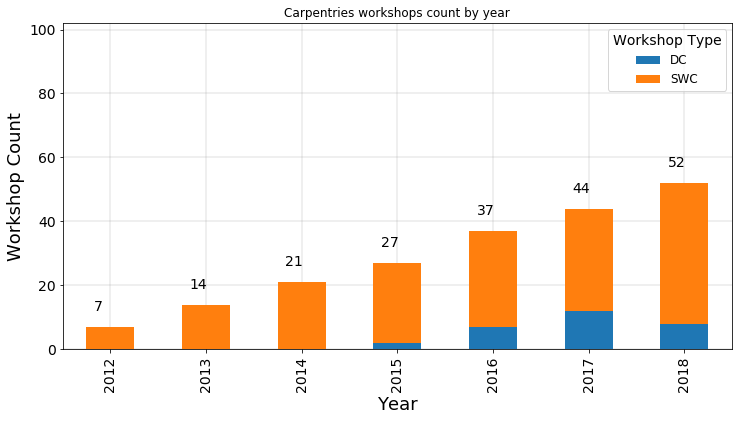

In [6]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

width = .5 # Set width of bar
title = "Carpentries workshops count by year"

# Set axes labels and legend
ax.set_xlabel("Year")
ax.set_ylabel("Workshop Count")
# ax.legend(title="Workshop Type", fontsize=12)

ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

# Plot chart
workshops_by_carpentry_year.plot(y = ["DC", "SWC"], kind='bar', ax=ax, width=width,  title=title, stacked=True,)

leg = ax.legend(fontsize=12)
leg.set_title(title="Workshop Type", prop={'size':14,})


# Customize the gridlines
ax.grid(linestyle='-', linewidth='0.25', color='gray')

# Create a new dataframe that has just the total number of workshops by year
totals = workshops_by_carpentry_year['DC'] + workshops_by_carpentry_year['SWC']
years = list(totals.index)


# Figure out what the xmarks values are (xtick values; they are not year like you'd think)
# Add them to an empty list
# The list will be double what's expected as it goes through all the stacked values
xmarks = []
for p in ax.patches:
#     print("X: ", p.get_x())
#     print("Y: ", p.get_height())
    xmarks.append(p.get_x())


# Make an empty list to be populated with a tuple for each stack
# Go through the length of the totals series
# Add to the empty list a tuple: (position in totals df, position in xmarks list)
t = []

for y in range(len(totals)):
    t.append((list(totals)[y], xmarks[y]))


# Annotate the stacked bar chart with 
# (annotation text, position of text)
for p in t:
    ax.annotate(str(p[0]), (p[1] + .08, p[0] + 5), fontsize=14)

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)    

ax.set_ylim(0,max(totals) + 50)

    
# Display the plot   
plt.show()


# See
# https://stackoverflow.com/questions/40783669/stacked-bar-plot-by-group-count-on-pandas-python





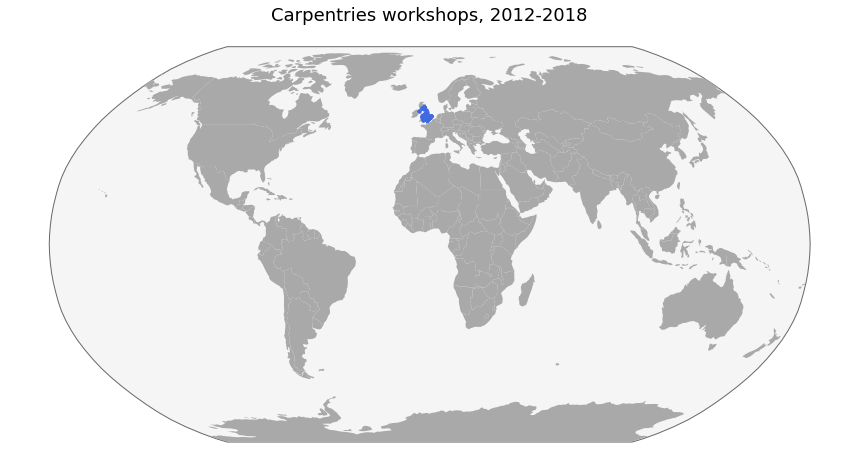

In [7]:
workshops_with_location = workshops[workshops.latitude.notnull()]
workshops_with_location = workshops_with_location[workshops_with_location.longitude.notnull()]

# For more info see 
# https://www.earthdatascience.org/courses/earth-analytics-python/spatial-data-vector-shapefiles/intro-to-coordinate-reference-systems-python/
# https://github.com/geopandas/geopandas/issues/245

# Make simple df with just the latlon columns
latlon = workshops_with_location[['longitude', 'latitude']]

# world map with latlong projections
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs(epsg=4326) #.to_crs('+proj=robin') # world map

# Turn latlon into list of shapely points
q  = [Point(xy) for xy in latlon.values]

# Create geodataframe using these points
q = gpd.GeoDataFrame(q, columns = ['geometry'])

# q.head()
# This is a "naive" object; need to explicitly set the crs to 4326 (latlon)
q.crs = {'init': 'epsg:4326', 'no_defs': True}

# Now translate both latlons to robinson projection - a bit "rounder"
# world = world.to_crs('+proj=robin')
q = q.to_crs('+proj=robin')


fig, ax = plt.subplots(figsize=(15, 8))

# Not sure what alpha means
bbox_robinson.plot(ax=ax, alpha=1, color='whitesmoke', edgecolor='dimgray')


world_robinson.plot(color='darkgrey', ax=ax,)

q.plot(ax=ax, color='royalblue', marker='o', markersize=10)

# ax.axis('off')

# facecolor will not work if ax.axis is off
# ax.patch.set_facecolor('whitesmoke')
# # Drop x & y axis ticks
plt.xticks([], [])
plt.yticks([], [])

ax.set_title("Carpentries workshops, 2012-2018")
ax.title.set_size(18)



# Make the axes invisible by making them the same color as the background
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')



plt.show()




In [8]:
workshops_current_year = workshops[workshops['start_date'].dt.year == current_year].copy()
workshops_current_year.attendance.fillna(0, inplace=True)
current_year_no_attendance = workshops_current_year[workshops_current_year.attendance ==0].copy()
percent_missing_attendance =  len(current_year_no_attendance)/len(workshops_current_year) * 100
percent_missing_attendance = int(percent_missing_attendance)

# percent_missing_attendance

## Learners and Attendance

In {{ current_year }}, {{ percent_missing_attendance }}% of workshops do not have attendance recorded.  Below are all workshops missing attendance.

In [9]:
display(current_year_no_attendance)

,slug,start_date,attendance,host_name,country2,latitude,longitude,url,country,country3,workshop_type
1360,2018-01-11-oxford,2018-01-11,0.0,University of Oxford,GB,51.752771,-1.214858,https://verdurin.github.io/2018-01-11-lindgren-python/,United Kingdom,GBR,SWC
1393,2018-02-12-Imperial,2018-02-12,0.0,Imperial College London,GB,51.498800,-0.174877,https://kmichali.github.io/2018-02-12-Imperial/,United Kingdom,GBR,SWC
1397,2018-02-19-edinburgh,2018-02-19,0.0,University of Edinburgh,GB,55.922530,-3.171358,https://marioa.github.io/2018-02-19-edinburgh/,United Kingdom,GBR,SWC
1403,2018-02-22-KCL,2018-02-22,0.0,King's College London,GB,51.504001,-0.087794,https://tavareshugo.github.io/2018-02-22-KCL/,United Kingdom,GBR,DC
1409,2018-02-26-Leicester,2018-02-26,0.0,University of Leicester,GB,52.620365,-1.124965,https://hpcarcher.github.io/2018-02-26-Leicester/,United Kingdom,GBR,SWC
1444,2018-03-19-Imperial,2018-03-19,0.0,Imperial College London,GB,51.498800,-0.174877,https://kmichali.github.io/2018-03-19-Imperial/,United Kingdom,GBR,SWC
1463,2018-03-29-standrews,2018-03-29,0.0,University of St. Andrews,GB,56.341241,-2.809415,https://starescomp.github.io/2018-03-29-standrews/,United Kingdom,GBR,SWC
1477,2018-04-12-southampton-swc,2018-04-12,0.0,University of Southampton,GB,50.936714,-1.396600,https://southampton-rsg.github.io/2018-04-12-southampton-swc/,United Kingdom,GBR,SWC
1486,2018-04-23-Imperial,2018-04-23,0.0,Imperial College London,GB,51.498800,-0.174877,https://kmichali.github.io/2018-04-23-Imperial/,United Kingdom,GBR,SWC
1502,2018-05-03-KCL,2018-05-03,0.0,King's College London,GB,51.504001,-0.087794,https://kpoterlowicz.github.io/2018-05-03-KCL/,United Kingdom,GBR,DC


In [10]:
# Learners by year


# Actual data for learners by year through 2018
# Projections for 2018 are calculated below

learners_by_year = workshops.groupby([workshops['start_date'].dt.year, 'workshop_type'])['attendance'].sum().unstack()
learners_by_year = learners_by_year.fillna(0)
# learners_by_year.rename(columns={'slug': 'learner_count'}, inplace=True)
# # workshops_by_country_year['total'] = workshops_by_country_year.sum(axis=1)
# learners_by_year.columns.names = ['Year']
# # workshops_by_country_year[current_year] = workshops_by_country_year[current_year]/.75
learners_by_year = learners_by_year.astype(int)

# # display(workshops_by_country_year)

# ##############

# Last year's attendance by year through the comparison date
# # Take *all* of last year's workshop by the com date and group them by Carpentry type
last_year_to_comp_date_attendance = last_year_workshops_to_comp_date.groupby([workshops['start_date'].dt.year, 'workshop_type'])['attendance'].sum().unstack()
# # # current_year_projected.rename({1:current_year}, inplace=True)
# last_year_to_comp_date_by_country.rename(columns={'slug':last_year}, inplace=True)

# Last year's workshops attendance by year total
# # Get just the last_year column from the workshops_by_country_year df
learners_last_year = learners_by_year.loc[[last_year]]

# Rename the rows so we can run calculations on them
learners_by_year.rename({current_year:1}, inplace=True)

x = last_year_to_comp_date_attendance/learners_last_year


x.rename({last_year:1}, inplace=True)

# learners_by_year.loc[[2018]]/x.loc[[2017]]
# display(x.loc[[2017]])
# display(learners_by_year.loc[[2018]])
# learners_by_year.loc[[2018]]/x.loc[[2017]]
learners_by_year.loc[[1]] = learners_by_year.loc[[1]]/x
learners_by_year.rename({1:current_year}, inplace=True)
learners_by_year = learners_by_year.round(0)
learners_by_year = learners_by_year.astype(int)


learners_by_year.index.name = 'Year'
learners_by_year.columns.name = "Workshop Type"


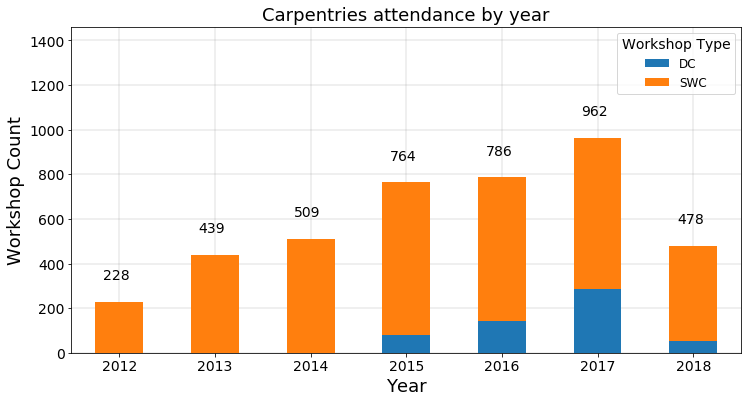

In [11]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

width = .5 # Set width of bar
title = "Carpentries attendance by year"

# Plot chart
# Having position=1 as an argument will make the bars not be centered on the x ticks
learners_by_year.plot(y = ["DC", "SWC"], kind='bar', ax=ax, width=width, title=title, stacked=True,)

# Set axes labels and legend
ax.set_xlabel("Year")
ax.set_ylabel("Workshop Count")
# ax.legend(title="Workshop Type", fontsize=12)
leg = ax.legend(fontsize=12)
leg.set_title(title="Workshop Type", prop={'size':14,})
ax.title.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)



# Customize the gridlines
ax.grid(linestyle='-', linewidth='0.25', color='gray')

# Create a new dataframe that has just the total number of workshops by year
totals = learners_by_year['DC'] + learners_by_year['SWC']
years = list(totals.index)


# Figure out what the xmarks values are (xtick values; they are not year like you'd think)
# Add them to an empty list
# The list will be double what's expected as it goes through all the stacked values
xmarks = []
for p in ax.patches:
#     print("X: ", p.get_x())
#     print("Y: ", p.get_height())
    xmarks.append(p.get_x())


# Make an empty list to be populated with a tuple for each stack
# Go through the length of the totals series
# Add to the empty list a tuple: (position in totals df, position in xmarks list)
t = []

for y in range(len(totals)):
    t.append((list(totals)[y], xmarks[y]))


# Annotate the stacked bar chart with 
# (annotation text, position of text)
for p in t:
    ax.annotate(str(p[0]), (p[1] + .08, p[0] + 100), fontsize=14)

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)    

ax.set_ylim(0,max(totals) + 500)

    
# Display the plot   
plt.show()


# See
# https://stackoverflow.com/questions/40783669/stacked-bar-plot-by-group-count-on-pandas-python




